In [1]:
!pip install librosa

   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------- ----------------- 1.6/2.8 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 7.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 9.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   --- ------------------------------------ 2.9/30.3 MB 14.0 MB/s eta 0:00:02
   -------- ------------------------------- 6.6/30.3 MB 14.9 MB/s eta 0:00:02
   --------------- ------------------------ 11.5/30.3 MB 18.0 MB/s eta 0:00:02
   ------------------------ --------------- 18.4/30.3 MB 21.8 MB/s eta 0:00:01
   ------------------------------ --------- 23.1/30.3 MB 22.5 MB/s eta 0:00:01
   ------------------------------------ --- 27.8/30.3 MB 22.0 MB/s eta 0:00:01
   ---------------------------------------- 30.3/30.3 MB 21.4 MB/s eta 0:00:00


In [2]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


                                           file_path  emotion  actor
0  Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...  neutral      1
1  Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...  neutral      1
2  Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...  neutral      1
3  Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...  neutral      1
4  Audio_Speech_Actors_01-24\Actor_01\03-01-02-01...     calm      1


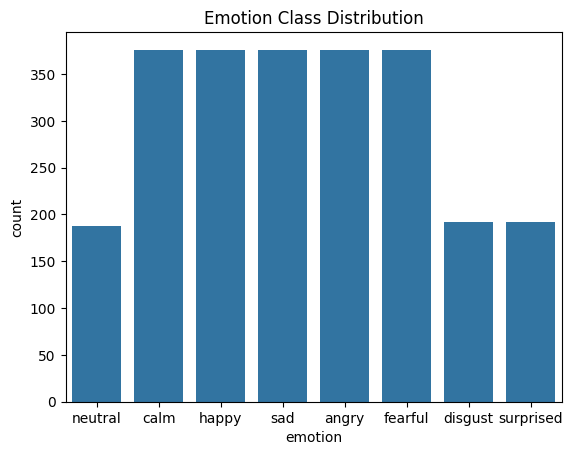

In [14]:
# Define the dataset path
DATASET_PATH1 = "Audio_Speech_Actors_01-24"
DATASET_PATH2 = "Audio_Song_Actors_01-24"

# Emotion mapping (only keeping happy, sad, angry, neutral)
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# List to store extracted data
data = []

# Loop through each actor folder
for actor_folder in os.listdir(DATASET_PATH1):
    actor_path = os.path.join(DATASET_PATH1, actor_folder)
    
    if os.path.isdir(actor_path):  # Ensure it's a folder
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):  # Process only audio files
                parts = file.split("-")  # Split filename by '-'
                
                modality = parts[0]  # 03 = audio-only
                emotion = parts[2]    # Extract emotion
                actor = parts[-1].split(".")[0]  # Extract actor number
                
                # Filter only selected emotions
                if emotion in emotion_map:
                    label = emotion_map[emotion]  # Map emotion to label
                    file_path = os.path.join(actor_path, file)  # Full path
                    
                    # Append data (file path, label, actor)
                    data.append([file_path, label, int(actor)])

for actor_folder in os.listdir(DATASET_PATH2):
    actor_path = os.path.join(DATASET_PATH2, actor_folder)
    
    if os.path.isdir(actor_path):  # Ensure it's a folder
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):  # Process only audio files
                parts = file.split("-")  # Split filename by '-'
                
                modality = parts[0]  # 03 = audio-only
                emotion = parts[2]    # Extract emotion
                actor = parts[-1].split(".")[0]  # Extract actor number
                
                # Filter only selected emotions
                if emotion in emotion_map:
                    label = emotion_map[emotion]  # Map emotion to label
                    file_path = os.path.join(actor_path, file)  # Full path
                    
                    # Append data (file path, label, actor)
                    data.append([file_path, label, int(actor)])

# Convert to DataFrame
df = pd.DataFrame(data, columns=["file_path", "emotion", "actor"])

# Display sample rows
print(df.head())

# Check class distribution
sns.countplot(x="emotion", data=df)
plt.title("Emotion Class Distribution")
plt.show()


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  2452 non-null   object
 1   emotion    2452 non-null   object
 2   actor      2452 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 57.6+ KB


In [16]:
df

,file_path,emotion,actor
0,Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...,neutral,1
1,Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...,neutral,1
2,Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...,neutral,1
3,Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...,neutral,1
4,Audio_Speech_Actors_01-24\Actor_01\03-01-02-01...,calm,1
...,...,...,...
2447,Audio_Song_Actors_01-24\Actor_24\03-02-06-01-0...,fearful,24
2448,Audio_Song_Actors_01-24\Actor_24\03-02-06-02-0...,fearful,24
2449,Audio_Song_Actors_01-24\Actor_24\03-02-06-02-0...,fearful,24
2450,Audio_Song_Actors_01-24\Actor_24\03-02-06-02-0...,fearful,24


In [17]:
def extract_features(file_path, mfcc_num=40):
    """
    Extract MFCC features from an audio file.
    
    Args:
    - file_path (str): Path to the audio file
    - mfcc_num (int): Number of MFCC coefficients to extract
    
    Returns:
    - mfccs (np.array): Extracted MFCC feature array (flattened)
    """
    try:
        audio, sr = librosa.load(file_path, sr=22050)  # Load audio
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=mfcc_num)  # Extract MFCC
        
        # Mean pooling (flattening the MFCCs)
        mfccs = np.mean(mfccs, axis=1)
        
        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None  # Return None for failed cases

# Apply feature extraction to all files
X, y = [], []

for index, row in df.iterrows():
    features = extract_features(row["file_path"])
    if features is not None:
        X.append(features)
        y.append(row["emotion"])

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Display shape
print(f"Feature shape: {X.shape}, Labels shape: {y.shape}")


Feature shape: (2452, 40), Labels shape: (2452,)


In [18]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Encode emotion labels into numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize MFCC features (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Display shapes
print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")


Training set shape: (1961, 40), Testing set shape: (491, 40)


📌 SVM Model Performance:
              precision    recall  f1-score   support

       angry       0.76      0.80      0.78        75
        calm       0.52      0.64      0.57        75
     disgust       0.48      0.31      0.38        39
     fearful       0.51      0.61      0.55        75
       happy       0.67      0.57      0.62        75
     neutral       0.72      0.55      0.63        38
         sad       0.55      0.55      0.55        75
   surprised       0.51      0.46      0.49        39

    accuracy                           0.59       491
   macro avg       0.59      0.56      0.57       491
weighted avg       0.59      0.59      0.59       491

📌 Random Forest Model Performance:
              precision    recall  f1-score   support

       angry       0.84      0.83      0.83        75
        calm       0.71      0.89      0.79        75
     disgust       0.58      0.56      0.57        39
     fearful       0.75      0.67      0.70        75
       happy      

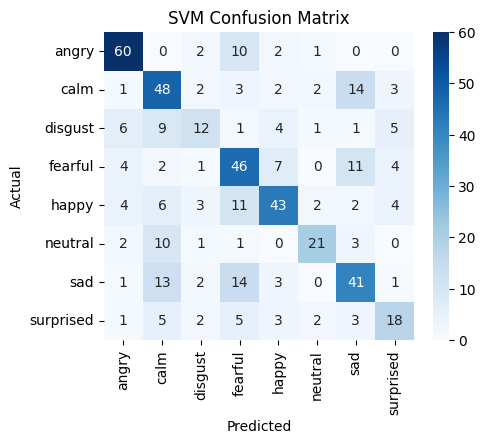

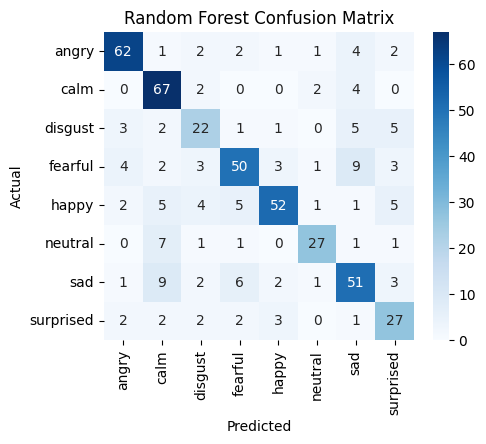

In [19]:
# Train Support Vector Machine (SVM) model
svm_model = SVC(kernel="linear", probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
svm_preds = svm_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

# Evaluate SVM
print("📌 SVM Model Performance:")
print(classification_report(y_test, svm_preds, target_names=label_encoder.classes_))

# Evaluate Random Forest
print("📌 Random Forest Model Performance:")
print(classification_report(y_test, rf_preds, target_names=label_encoder.classes_))

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, svm_preds, "SVM Confusion Matrix")
plot_confusion_matrix(y_test, rf_preds, "Random Forest Confusion Matrix")


In [23]:
def predict_emotion(file_path, model, scaler, label_encoder, mfcc_num=40):
    """
    Predicts the emotion of a given audio file using the trained model.
    
    Args:
    - file_path (str): Path to the audio file
    - model (RandomForestClassifier): Trained emotion classifier
    - scaler (StandardScaler): Trained feature scaler
    - label_encoder (LabelEncoder): Trained label encoder
    - mfcc_num (int): Number of MFCC features to extract

    Returns:
    - Predicted emotion label (str)
    """
    # Extract MFCC features
    features = extract_features(file_path, mfcc_num)
    
    if features is None:
        return "Error: Could not extract features."

    # Scale features
    features = scaler.transform([features])  # Reshape for scaling

    # Predict emotion
    prediction = model.predict(features)
    
    # Convert numeric label back to emotion
    emotion_label = label_encoder.inverse_transform(prediction)[0]

    return emotion_label

# Example Usage
test_audio = "test4.opus"  # Change this to your test file path
predicted_emotion = predict_emotion(test_audio, rf_model, scaler, label_encoder)
print(f"Predicted Emotion: {predicted_emotion}")


Predicted Emotion: happy


In [22]:
import joblib

# Save the trained model, scaler, and label encoder
joblib.dump(rf_model, "emotion_rf_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("✅ Model, scaler, and label encoder saved successfully!")


✅ Model, scaler, and label encoder saved successfully!
